In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 256

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0) # Adds a fake dimension at the 0th axis
    return image.to(device, torch.float)


style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/iu_cover.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
print(style_img.size())

torch.Size([1, 3, 256, 256])


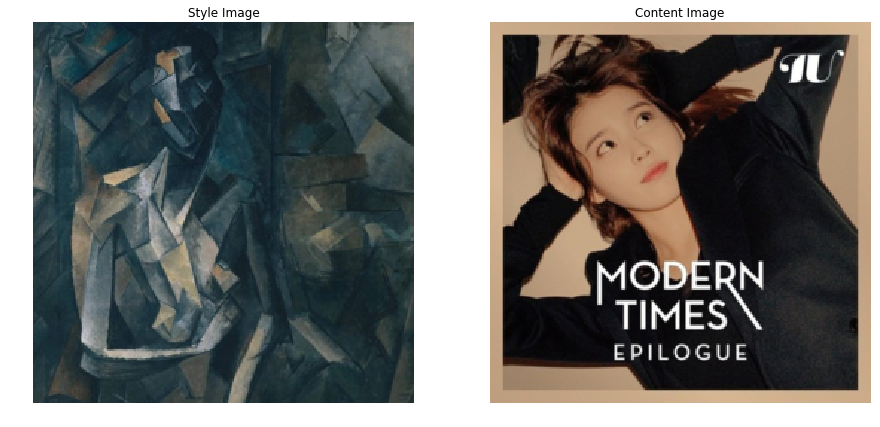

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(image)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')
plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')
plt.show()

In [4]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        
        # Detaching the target from the tree that computes the gradient dynamically.
        # Because this is not a variable. 
        # This target is like the content from some CNN architeceture and we don't want to 
        # update gradient for that CNN right?
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
def gram_matrix(input):
    # a is batch size
    # b is channels
    # c and d are the height and width
    a, b, c, d = input.size()
    
    # We change the view to be a matrix of b vectorized feature maps of size c * d
    # And a is just the batch size which is 1
    features = input.view(a * b, c * d)
    
    # By doing a matrix multiplication of features and its transpose, we get the Gram matrix.
    # Remember how torch.mm(X.t(), X) is the sort of 'covariance matrix' (if we remove the mean)?
    # Well, that covariance is the covariance between the features across the samples in the first axis. 
    # Here, we want the covariance in the feature map across the different feature maps. In the words of
    # the original paper: it's the correlations between different filter responses. Cool!
    
    G = torch.mm(features, features.t())
    
    return G

In [6]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        
        # So we now compute the gram matrix which is our indicator of the style
        # for the target, which we remember to detach from the CNN that computed it
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        # Now, for any input, we want to compute the gram matrix G and get the loss for it
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [7]:
# Get the pretrained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Pretrained model uses these normalization means and stds
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [8]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

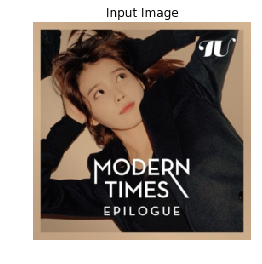

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_1', 'conv2', 'conv3', 'conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


# Copy from the tutorial..
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses# This is the original image
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
plt.show()

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1, content_weight=1):
    
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                imshow(input_img)
                plt.show()

            return style_score + content_score

        optimizer.step(closure)
        

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

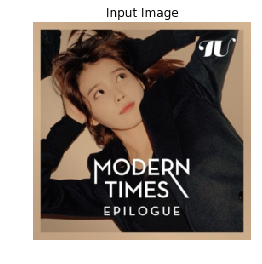

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 102474152.000000 Content Loss: 78.464394


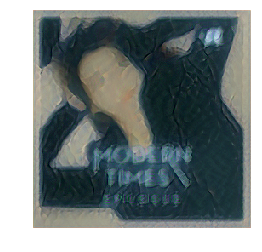

run [100]:
Style Loss : 43174480.000000 Content Loss: 82.451248


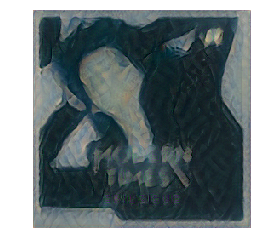

run [150]:
Style Loss : 11261123.000000 Content Loss: 86.839706


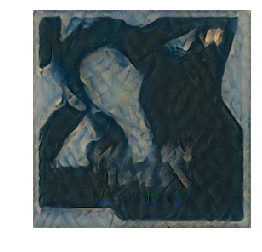

run [200]:
Style Loss : 4235212.000000 Content Loss: 91.531494


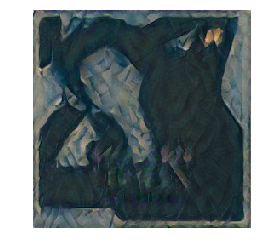

run [250]:
Style Loss : 2082494.750000 Content Loss: 94.496887


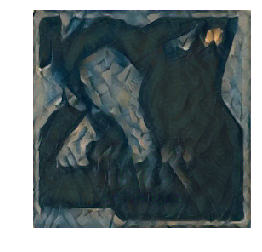

run [300]:
Style Loss : 1262519.625000 Content Loss: 95.913292


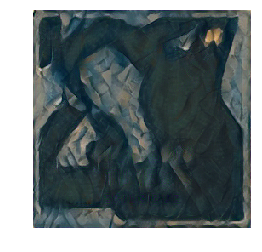

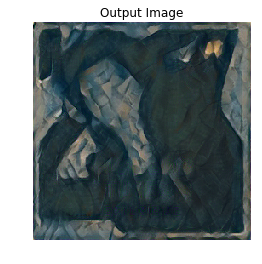

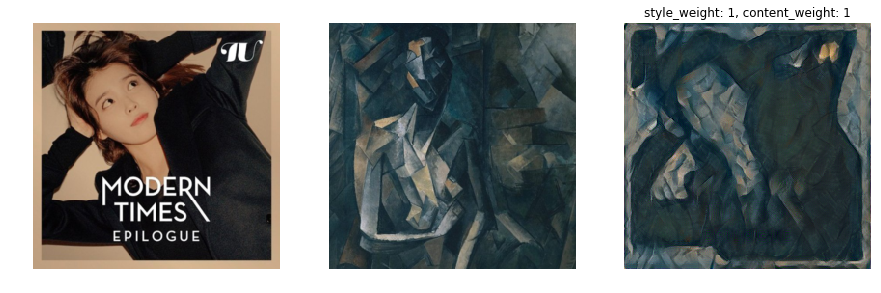

In [12]:
style_weight = 1
content_weight = 1

# This is the original image
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            style_weight=style_weight, content_weight=content_weight)

plt.figure()
imshow(output, title='Output Image')
plt.show()


plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
imshow(content_img)
plt.subplot(1, 3, 2)
imshow(style_img)
plt.subplot(1, 3, 3)
plt.title("style_weight: {}, content_weight: {}".format(style_weight, content_weight))
imshow(output)
plt.show()

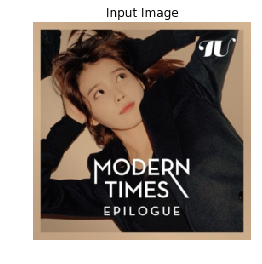

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 101433560.000000 Content Loss: 7608275.500000


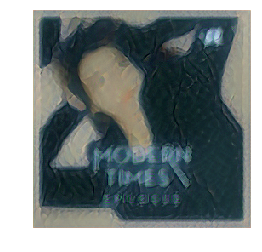

run [100]:
Style Loss : 40446100.000000 Content Loss: 7255437.500000


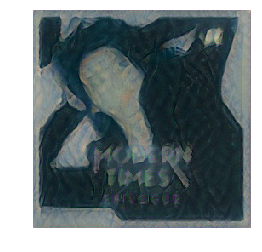

run [150]:
Style Loss : 13041746.000000 Content Loss: 6933667.000000


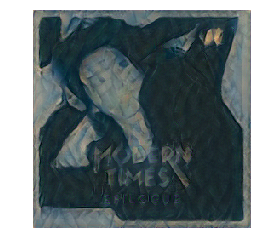

run [200]:
Style Loss : 4791389.000000 Content Loss: 6618525.000000


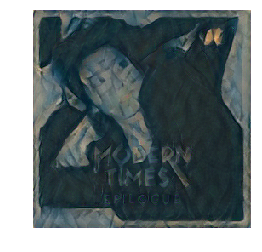

run [250]:
Style Loss : 2569784.250000 Content Loss: 6191534.000000


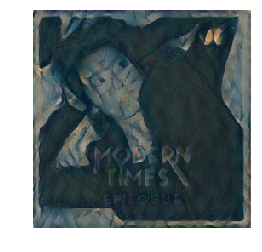

run [300]:
Style Loss : 1723199.500000 Content Loss: 5782559.000000


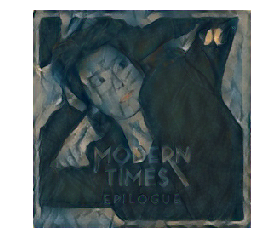

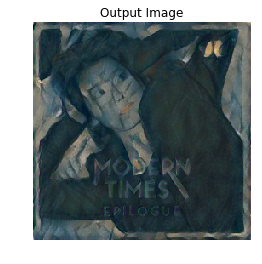

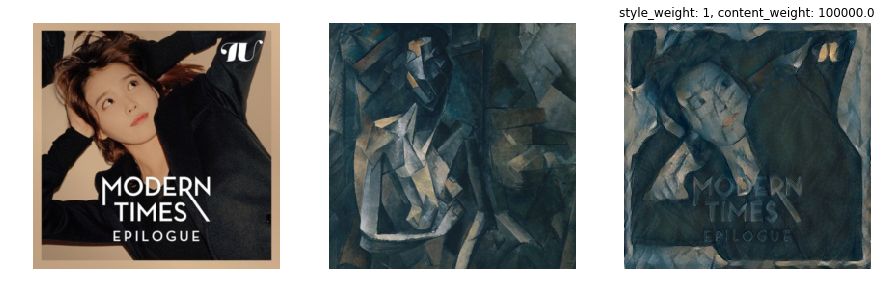

In [14]:
style_weight = 1
content_weight = 1e5

# White noise initialization
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            style_weight=style_weight, content_weight=content_weight)

plt.figure()
imshow(output, title='Output Image')
plt.show()


plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
imshow(content_img)
plt.subplot(1, 3, 2)
imshow(style_img)
plt.subplot(1, 3, 3)
plt.title("style_weight: {}, content_weight: {}".format(style_weight, content_weight))
imshow(output)
plt.show()

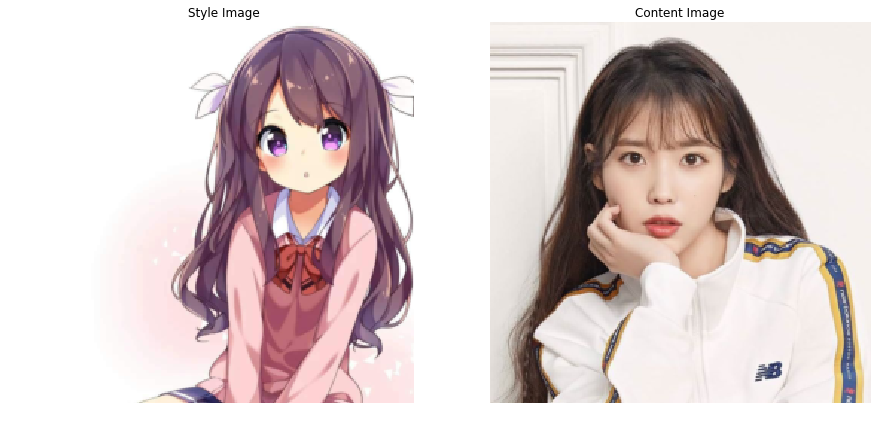

In [19]:
style_img = image_loader("./images/anime.jpg")
content_img = image_loader("./images/iu.jpg")

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')
plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')
plt.show()

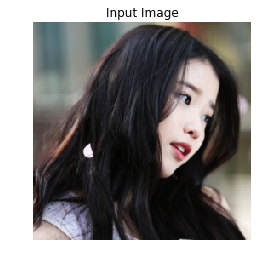

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 888685248.000000 Content Loss: 49.662910


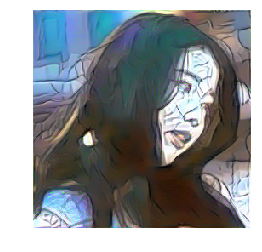

run [100]:
Style Loss : 189480336.000000 Content Loss: 58.858223


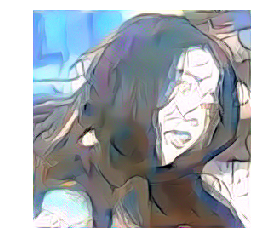

run [150]:
Style Loss : 54864744.000000 Content Loss: 61.491680


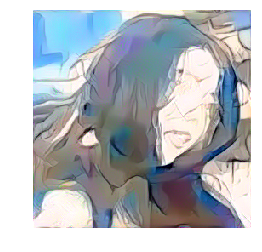

KeyboardInterrupt: 

In [18]:
style_weight = 1
content_weight = 1

# This is the original image
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            style_weight=style_weight, content_weight=content_weight)

plt.figure()
imshow(output, title='Output Image')
plt.show()


plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
imshow(content_img)
plt.subplot(1, 3, 2)
imshow(style_img)
plt.subplot(1, 3, 3)
plt.title("style_weight: {}, content_weight: {}".format(style_weight, content_weight))
imshow(output)
plt.show()

In [ ]:
style_weight = 1
content_weight = 1e5

# This is the original image
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
plt.show()

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 
                            style_weight=style_weight, content_weight=content_weight)

plt.figure()
imshow(output, title='Output Image')
plt.show()


plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
imshow(content_img)
plt.subplot(1, 3, 2)
imshow(style_img)
plt.subplot(1, 3, 3)
plt.title("style_weight: {}, content_weight: {}".format(style_weight, content_weight))
imshow(output)
plt.show()